In [71]:
# Libraries and utilities

import math
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns





from collections import defaultdict
from scipy.stats.stats import pearsonr

In [72]:
#Clustering utilities

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering,BisectingKMeans
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [73]:
# read dataset
df=pd.read_csv('prepared_ravdess_features.csv')
original_audio2=['length_ms','zero_crossings_sum','std','min', 'max','kur','skew']

In [74]:
#CREAZIONE NUOVO DATAFRAME SENZA FEATURE CATEGORICHE
continuos_df=df.copy()
continuos_df = continuos_df.drop(columns=['emotion','vocal_channel','emotional_intensity','statement','repetition','sex'],axis = 1)

In [75]:
X = continuos_df.values
y = np.array(df['emotion'])
y_map={"neutral":0,"calm":1,"happy":2,"sad":3,"angry":4,"fearful":5,"disgust":6,"surprised":7} #utile?
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)

In [76]:
continuos_df[original_audio2].head()

,length_ms,zero_crossings_sum,std,min,max,kur,skew
0,3737,16995,0.014482,-0.128632,0.138947,9.406061,0.273153
1,3904,13906,0.020417,-0.305725,0.263062,19.564187,0.292157
2,4671,18723,0.024317,-0.137482,0.166351,4.881241,0.302659
3,3637,11617,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,4404,15137,0.027522,-0.192169,0.242676,7.485109,0.414872


In [77]:
# Funzione per visualizzare SSE,Silhouette per tot istanze del K means
# utilizza il KneeLockator per identificare l ipotetico miglior K su cui va fatto tradeoff

#!pip install yellowbrick
#!pip install kneed
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

def res_K(df, features):
    print("Test effettuato sulle features:")
    print(features)
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[features])
    sse = {}
    silhouette = {}
    for k in range(2, 30):
        bkmeans = BisectingKMeans(n_clusters=k)
        bkmeans.fit(scaled_features)
        #L'inertia è la somma delle distanza degli esempio rispetto al centro del cluster più vicino
        sse[k] = bkmeans.inertia_
        silhouette[k] = silhouette_score(scaled_features, bkmeans.labels_)
        
    plt.figure()
    plt.style.use('seaborn-darkgrid')
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.show()
    kl = KneeLocator(
        range(2, 30), list(sse.values()), curve="convex", direction="decreasing"
    )
    
    print(kl.elbow)
    

    

    print("***************************************")
    
    return sse, silhouette, kl.elbow

TEST BISECTING K-MEANS

Test effettuato sulle features:
['length_ms', 'zero_crossings_sum', 'std', 'min', 'max', 'kur', 'skew']


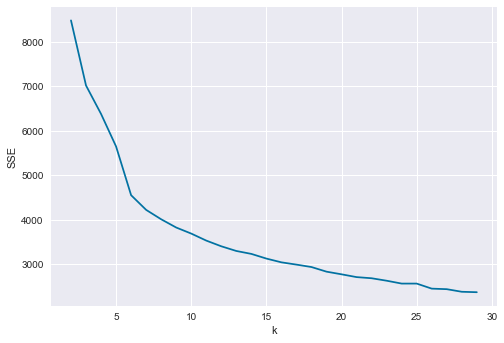

7
***************************************
k = 2| SSE = 8480.936067202332| silhouette = 0.5254525216896048
k = 3| SSE = 7018.224689331392| silhouette = 0.2320046338276761
k = 4| SSE = 6379.260293571602| silhouette = 0.21167756147744896
k = 5| SSE = 5647.760112211631| silhouette = 0.19984033136827908
k = 6| SSE = 4553.039385392441| silhouette = 0.2151926039723797
k = 7| SSE = 4223.258328532114| silhouette = 0.21680773352090538
k = 8| SSE = 4011.93209873668| silhouette = 0.20244282987765808
k = 9| SSE = 3826.759673525437| silhouette = 0.1755660263577847
k = 10| SSE = 3690.687433774836| silhouette = 0.1592491272081889
k = 11| SSE = 3533.1718982240454| silhouette = 0.15589817014801408
k = 12| SSE = 3404.966971992956| silhouette = 0.15413087404030595
k = 13| SSE = 3299.717050434514| silhouette = 0.15097112770047913
k = 14| SSE = 3233.9368643989087| silhouette = 0.13737256602675513
k = 15| SSE = 3128.9841643209124| silhouette = 0.1402676865534302
k = 16| SSE = 3044.4776495743313| silhouette =

In [78]:
sse, silhouette, kl = res_K(df, original_audio2)
for i in range(2, 30):
    print("k = " + str(i) + "| SSE = " + str(sse[i]) + "| silhouette = " + str(silhouette[i]))
print(kl)

In [79]:
# Sono stati analizzati nello specifico k=7,8,9  e k=7 è il imgliore dei 3 test specifici

X11=continuos_df[original_audio2]
scaler = RobustScaler() 
scaler.fit(X11)
X11_scal = scaler.transform(X11)

bkmeans = BisectingKMeans(n_clusters=7)
bkmeans.fit(X11_scal)

print(bkmeans.inertia_)
print(silhouette_score(X11_scal,bkmeans.labels_))
np.unique(bkmeans.labels_, return_counts=True)


4222.691884157896
0.21696662930804242


(array([0, 1, 2, 3, 4, 5, 6]),
 array([241,  96, 581, 523, 320,  62, 594], dtype=int64))

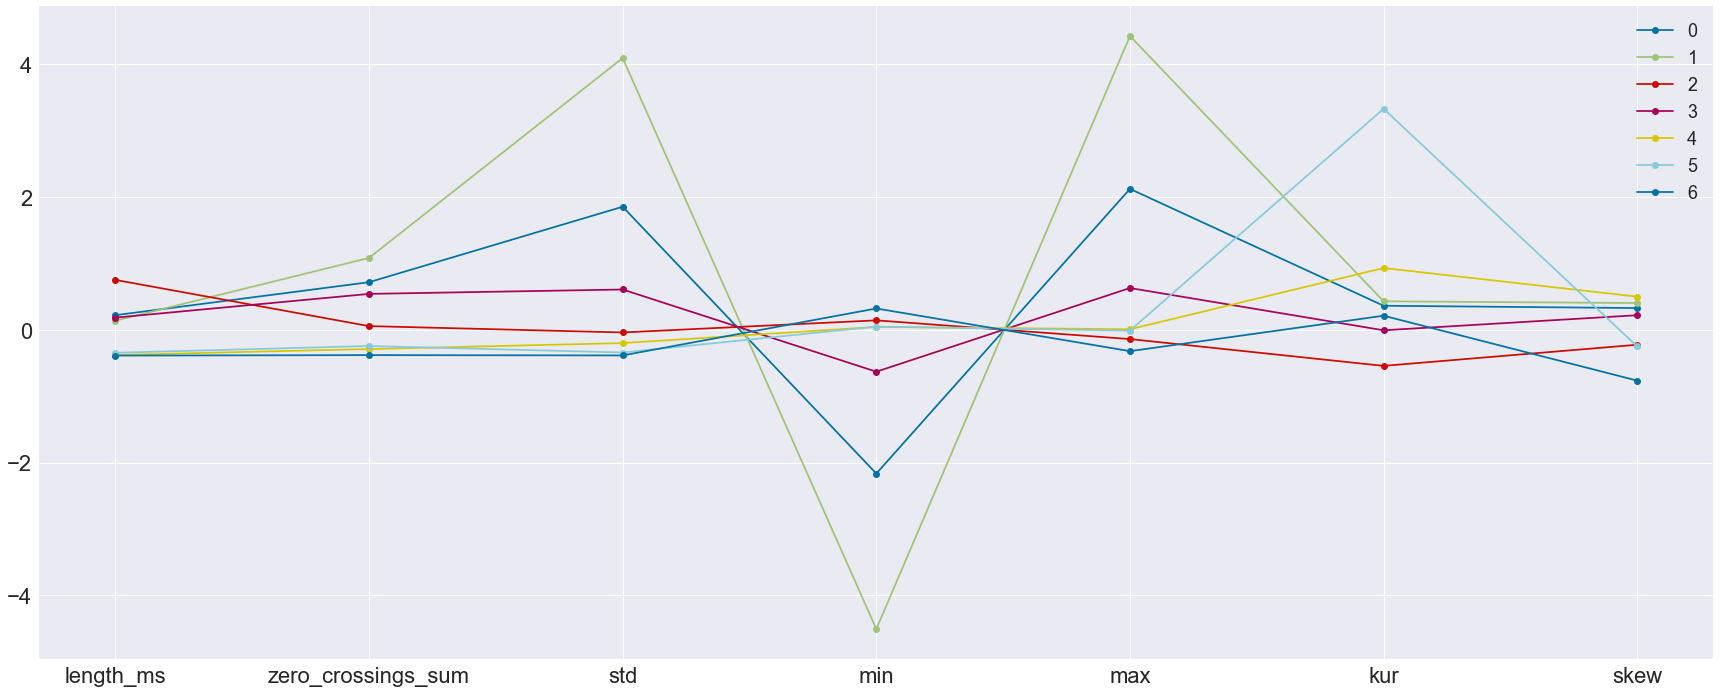

In [83]:


centers = bkmeans.cluster_centers_


plt.figure(figsize=(30, 12))


for i in range(len(centers)): # itero sulle coordinate dei 9 centri
    plt.plot(centers[i], marker='o', label=i)
    
plt.xticks(range(0,len(original_audio2)), original_audio2, fontsize=15)
#plt.yticks(fontsize=15)

plt.tick_params(axis='both', which='major', labelsize=22)



plt.legend(fontsize=18, loc='best')
#plt.grid(axis='y')

plt.show()

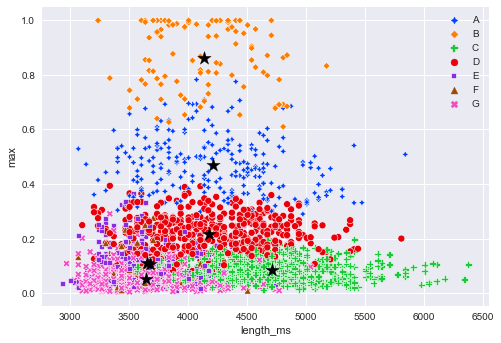

In [90]:
centers = bkmeans.cluster_centers_
centers = scaler.inverse_transform(centers) #denormalizziamo le coordinate dei centroidi

continuos_df['bkmeans_labels'] = bkmeans.labels_ # creo nuova variabile per il dataframe e assegno ogni punto al suo cluster
continuos_df['bkmeans_labels'] = continuos_df['bkmeans_labels'].map({0:"A", 1: "B", 2: "C",3:"D",4:"E",5:"F",6:"G"})

sns.scatterplot(data=continuos_df, x="length_ms", y="max", hue='bkmeans_labels', style='bkmeans_labels',
                palette="bright", hue_order=["A","B","C","D","E","F","G"])
plt.legend()
plt.scatter(centers[:,0], centers[:,4], c='black', marker='*', s=200) # per vedere l indice associato a 4 guardare scatterplot
plt.show()

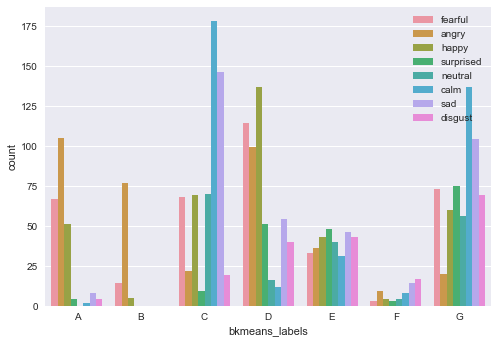

In [91]:
#COUNTPLOT
sns.countplot(data=continuos_df, x='bkmeans_labels', hue=y,order=["A","B","C","D","E","F","G"])
plt.show()

In [93]:
emotion_labels=pd.crosstab(df['emotion'],continuos_df['bkmeans_labels'])
emotion_labels

bkmeans_labels,A,B,C,D,E,F,G
emotion,,,,,,,
angry,105,77,22,99,36,9,20
calm,2,0,178,12,31,8,137
disgust,4,0,19,40,43,17,69
fearful,67,14,68,114,33,3,73
happy,51,5,69,137,43,4,60
neutral,0,0,70,16,40,4,56
sad,8,0,146,54,46,14,104
surprised,4,0,9,51,48,3,75


TESTING X-MEANS

In [95]:
from pyclustering.cluster import xmeans

xm = xmeans.xmeans(X11_scal)
xm.process()

clusters = xm.get_clusters()


In [96]:
clusters = xm.get_clusters()

In [97]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [102]:
labels = clusters_to_labels(clusters)
np.unique(labels,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([216, 200, 119, 101,  20, 241, 128, 105, 174, 211, 254, 176, 127,
        149,  78, 118], dtype=int64))

In [103]:
centers = np.array(xm.get_centers())
centers_unscaled = scaler.inverse_transform(centers)

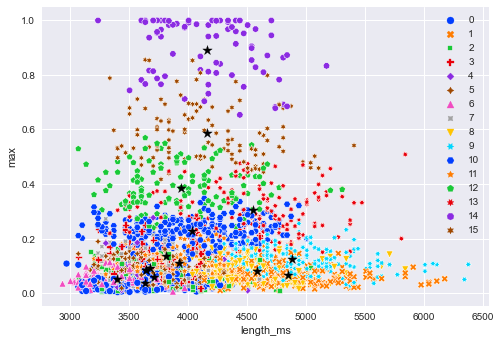

In [107]:
sns.scatterplot(data=df, x="length_ms", y="max", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,4], color="black", marker="*", s=100)

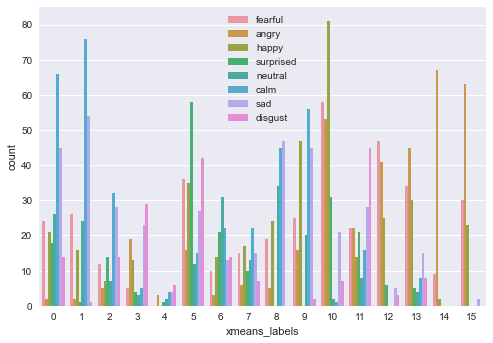

In [110]:
continuos_df['xmeans_labels'] = labels # creo nuova variabile per il dataframe e assegno ogni punto al suo cluster
continuos_df['xmeans_labels'] = continuos_df['xmeans_labels']




#COUNTPLOT
sns.countplot(data=continuos_df, x='xmeans_labels', hue=y)
plt.show()

In [112]:
emotion_labels=pd.crosstab(df['emotion'],continuos_df['xmeans_labels'])
emotion_labels

xmeans_labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
emotion,,,,,,,,,,,,,,,,
angry,2,2,5,19,3,16,3,6,5,16,53,22,41,45,67,63
calm,66,76,32,5,4,15,22,22,45,56,1,16,0,8,0,0
disgust,14,1,14,29,6,42,14,7,0,2,7,45,3,8,0,0
fearful,24,26,12,5,0,36,10,15,19,25,58,22,47,34,9,30
happy,21,16,7,13,0,35,14,17,24,47,81,14,25,30,2,23
neutral,26,24,7,3,2,12,31,13,34,20,2,8,0,4,0,0
sad,45,54,28,23,4,27,13,15,47,45,21,28,5,15,0,2
surprised,18,1,14,4,1,58,21,10,0,0,31,21,6,5,0,0


TESTING OPTICS

In [200]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=10, max_eps=0.5)
optics.fit(X11_scal)

OPTICS(max_eps=0.5, min_samples=10)

In [201]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.2569842077807676

<AxesSubplot:xlabel='length_ms', ylabel='max'>

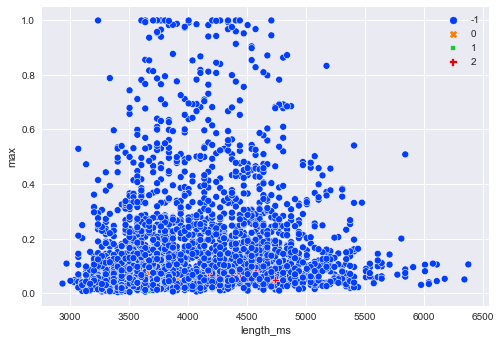

In [202]:
sns.scatterplot(data=df, x="length_ms", y="max", hue=optics.labels_, 
                palette="bright", style=optics.labels_)

In [203]:
np.unique(optics.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([2374,   11,   16,   16], dtype=int64))